=== การวางแผนแขนกลด้วย A* Search และการหลบหลีกสิ่งกีดขวาง ===

State เริ่มต้น:
State: Joints: [0.0, 0.0, 0.0]°
End effector position: (2.60, 0.00)
Goal position: (1.80, 0.50)
Distance to goal: 0.94
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------

กำลังรัน A* search...

พบคำตอบใน 12 ขั้นตอน!
Total cost: 2.40

กำลังแสดงผล 13 ขั้นตอนในเส้นทางคำตอบ...

ขั้นตอนที่ 0:
State: Joints: [0.0, 0.0, 0.0]°
End effector position: (2.60, 0.00)
Goal position: (1.80, 0.50)
Distance to goal: 0.94
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


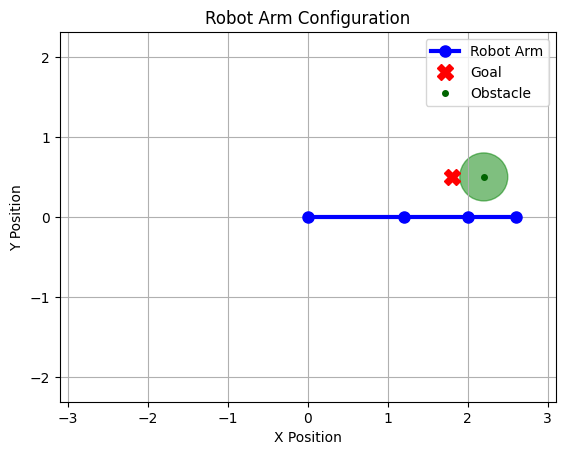


ขั้นตอนที่ 1:
State: Joints: [-11.5, 0.0, 0.0]°
End effector position: (2.55, -0.52)
Goal position: (1.80, 0.50)
Distance to goal: 1.26
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


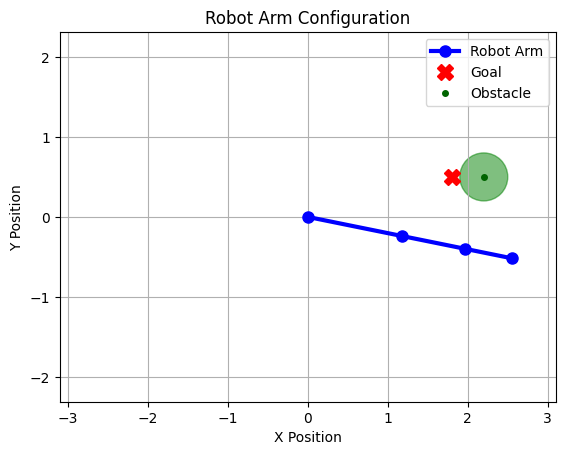


ขั้นตอนที่ 2:
State: Joints: [-11.5, 11.5, 0.0]°
End effector position: (2.58, -0.24)
Goal position: (1.80, 0.50)
Distance to goal: 1.07
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


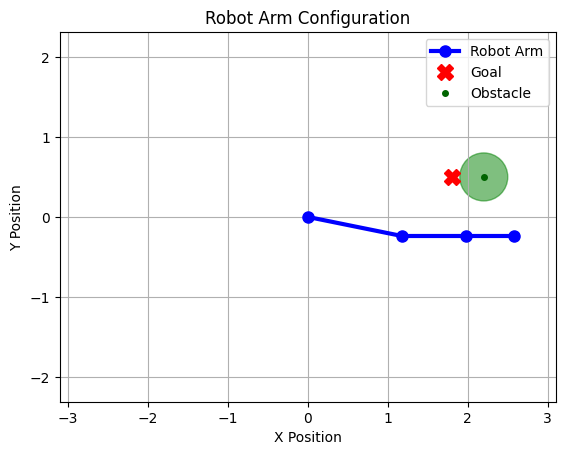


ขั้นตอนที่ 3:
State: Joints: [-11.5, 22.9, 0.0]°
End effector position: (2.55, 0.04)
Goal position: (1.80, 0.50)
Distance to goal: 0.88
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


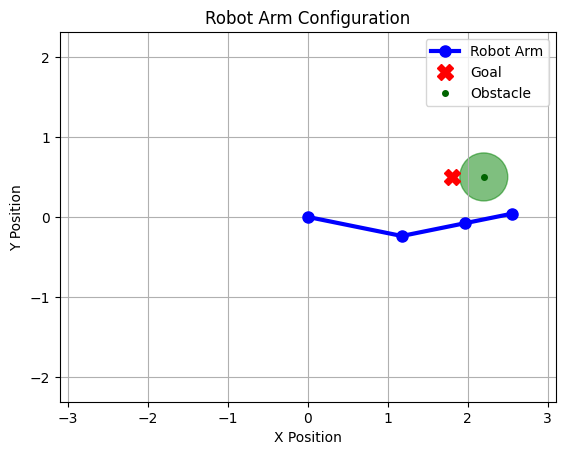


ขั้นตอนที่ 4:
State: Joints: [-22.9, 22.9, 0.0]°
End effector position: (2.51, -0.47)
Goal position: (1.80, 0.50)
Distance to goal: 1.20
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


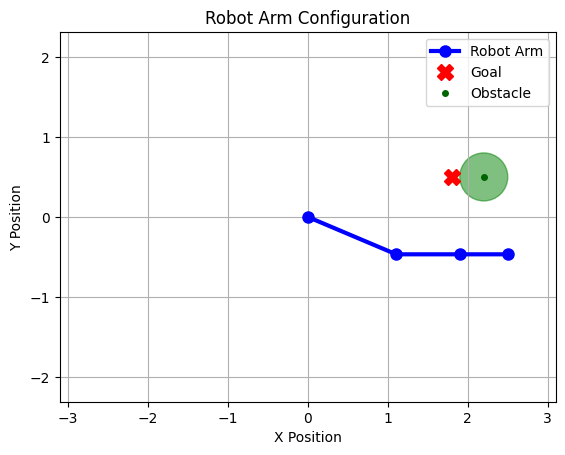


ขั้นตอนที่ 5:
State: Joints: [-22.9, 34.4, 0.0]°
End effector position: (2.48, -0.19)
Goal position: (1.80, 0.50)
Distance to goal: 0.97
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


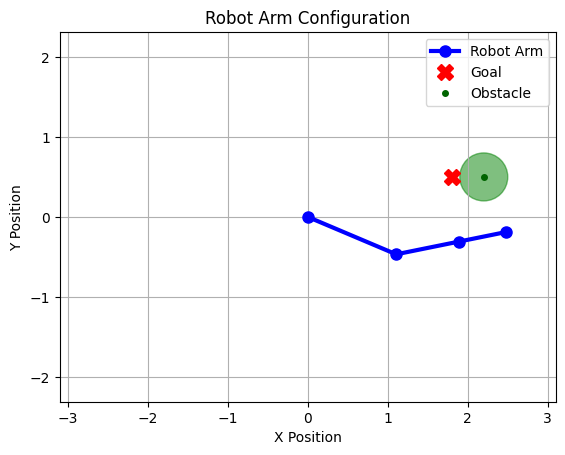


ขั้นตอนที่ 6:
State: Joints: [-22.9, 45.8, 0.0]°
End effector position: (2.39, 0.08)
Goal position: (1.80, 0.50)
Distance to goal: 0.73
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


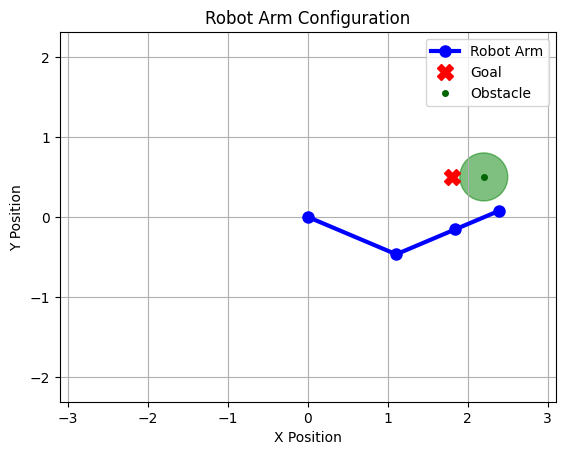


ขั้นตอนที่ 7:
State: Joints: [-34.4, 45.8, 0.0]°
End effector position: (2.36, -0.40)
Goal position: (1.80, 0.50)
Distance to goal: 1.06
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


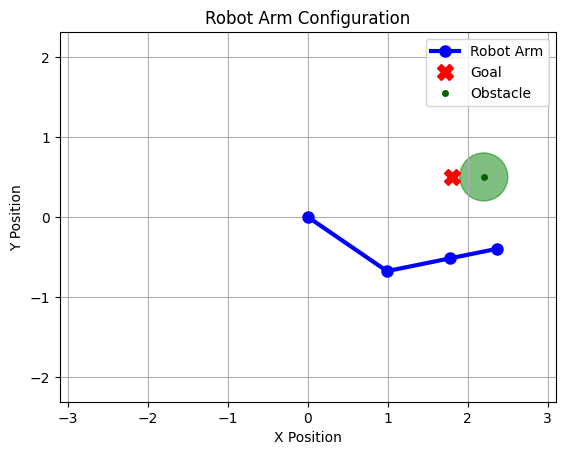


ขั้นตอนที่ 8:
State: Joints: [-34.4, 57.3, 0.0]°
End effector position: (2.28, -0.13)
Goal position: (1.80, 0.50)
Distance to goal: 0.79
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


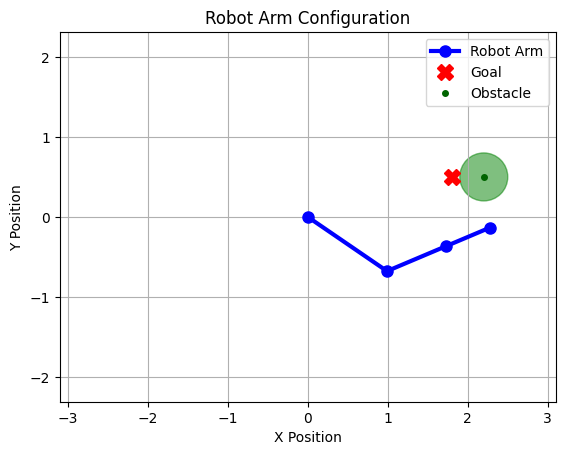


ขั้นตอนที่ 9:
State: Joints: [-34.4, 68.8, 0.0]°
End effector position: (2.15, 0.11)
Goal position: (1.80, 0.50)
Distance to goal: 0.52
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


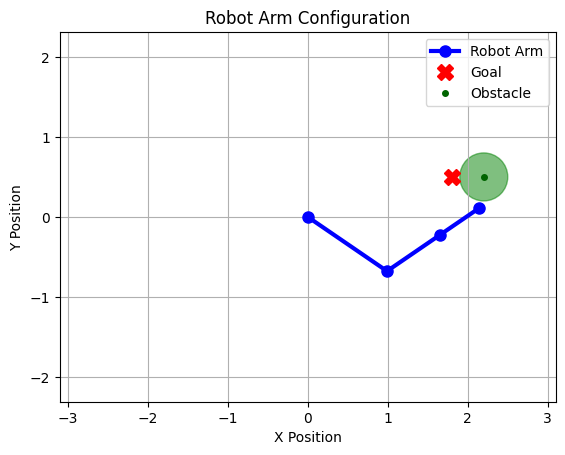


ขั้นตอนที่ 10:
State: Joints: [-34.4, 68.8, 11.5]°
End effector position: (2.07, 0.20)
Goal position: (1.80, 0.50)
Distance to goal: 0.40
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


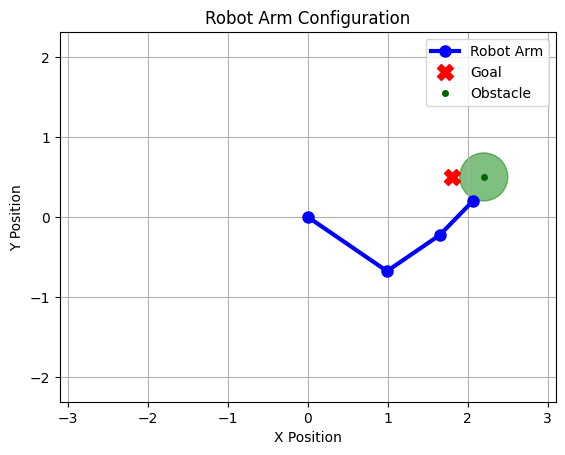


ขั้นตอนที่ 11:
State: Joints: [-34.4, 80.2, 11.5]°
End effector position: (1.87, 0.40)
Goal position: (1.80, 0.50)
Distance to goal: 0.12
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


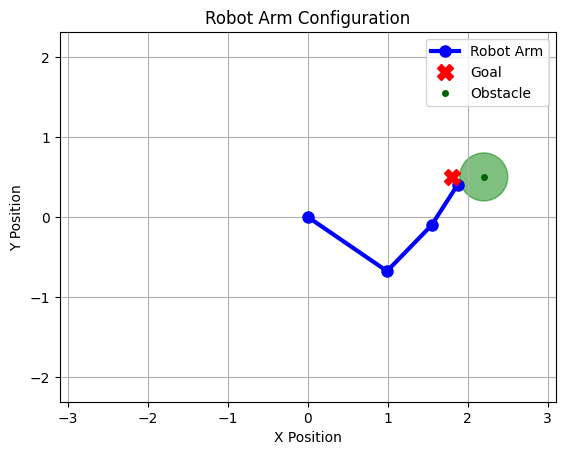


ขั้นตอนที่ 12:
State: Joints: [-34.4, 80.2, 22.9]°
End effector position: (1.77, 0.46)
Goal position: (1.80, 0.50)
Distance to goal: 0.06
Obstacle at: (2.20, 0.50) with radius 0.30
--------------------------------------------------


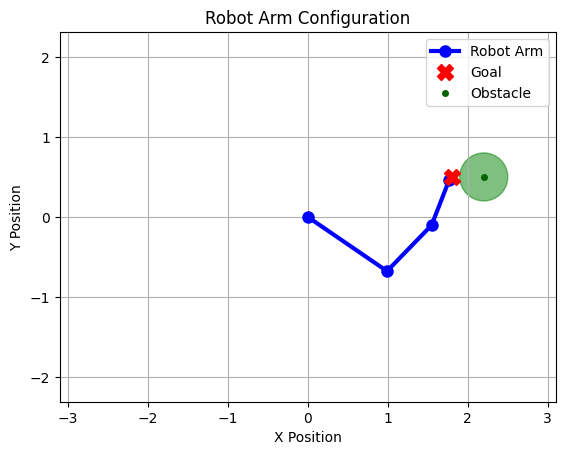

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import  List, Tuple
from kamgon import Problem, astar_search, Node

class RobotArmState:
    """
    คลาสสำหรับ State ของแขนกล
    เก็บข้อมูลมุมของข้อต่อ (Joint Angles)
    """
    def __init__(self, joint_angles: List[float]):
        self.joint_angles = tuple(joint_angles) # แปลงเป็น tuple เพื่อให้ hashable

    def __repr__(self):
        angles_deg = [math.degrees(angle) for angle in self.joint_angles]
        return f"Joints: {[round(a, 1) for a in angles_deg]}°"

    def __eq__(self, other):
        if not isinstance(other, RobotArmState):
            return False
        # พิจารณาว่า State เท่ากันหากมุมต่างกันไม่เกินค่า Tolerance ที่กำหนด
        return all(abs(a1 - a2) < 0.1 for a1, a2 in zip(self.joint_angles, other.joint_angles))

    def __hash__(self):
        # ปัดเศษมุมเพื่อใช้ในการ Hash
        rounded_angles = tuple(round(angle, 1) for angle in self.joint_angles)
        return hash(rounded_angles)
    
class RobotArmAction:
    """
    คลาสสำหรับ Action ของแขนกล
    เก็บข้อมูลว่าจะขยับข้อต่อ (Joint) ไหน และขยับไปเท่าไหร่
    """
    def __init__(self, joint_index: int, angle_change: float):
        self.joint_index = joint_index
        self.angle_change = angle_change

    def __repr__(self):
        return f"Joint {self.joint_index}: {math.degrees(self.angle_change):.1f}°"

class RobotArmProblemEnhance(Problem[RobotArmState, RobotArmAction]):
    """
    กำหนดปัญหาการวางแผนแขนกลพร้อมการหลบหลีกสิ่งกีดขวาง (Obstacle)
    เป้าหมาย: ย้ายปลายแขน (End Effector) ไปยังตำแหน่งเป้าหมายโดยไม่ชนสิ่งกีดขวาง
    """
    def __init__(self, link_lengths: List[float], obstacle_pos: Tuple[float, float],
                 goal_pos: Tuple[float, float], angle_step: float = 0.2,
                 max_angle: float = math.pi, obstacle_radius: float = 0.2):
        self.link_lengths = link_lengths
        self.obstacle_pos = obstacle_pos
        self.goal_pos = goal_pos
        self.angle_step = angle_step
        self.max_angle = max_angle
        self.num_joints = len(link_lengths)
        self.obstacle_radius = obstacle_radius

    def is_valid(self, state: RobotArmState) -> bool:
        """ตรวจสอบว่า Link ของแขนกลชนกับสิ่งกีดขวางหรือไม่"""
        p_obstacle = np.array(self.obstacle_pos)
        p_joint_start = np.array([0.0, 0.0])
        cumulative_angle = 0.0

        for length, joint_angle in zip(self.link_lengths, state.joint_angles):
            cumulative_angle += joint_angle
            p_joint_end = p_joint_start + np.array([length * math.cos(cumulative_angle), length * math.sin(cumulative_angle)])

            # ตรวจสอบระยะห่างจากจุดศูนย์กลางของสิ่งกีดขวางไปยังส่วนของเส้นตรงที่แทน Link
            line_vec = p_joint_end - p_joint_start
            point_vec = p_obstacle - p_joint_start
            line_len_sq = np.dot(line_vec, line_vec)

            if line_len_sq == 0.0:
                distance_sq = np.dot(point_vec, point_vec)
            else:
                # คำนวณจุดบนเส้น Link ที่ใกล้กับสิ่งกีดขวางที่สุด
                t = max(0, min(1, np.dot(point_vec, line_vec) / line_len_sq))
                projection = p_joint_start + t * line_vec
                distance_sq = np.dot(p_obstacle - projection, p_obstacle - projection)

            # หากระยะห่างน้อยกว่ารัศมีของสิ่งกีดขวาง แสดงว่าเกิดการชน
            if math.sqrt(distance_sq) < self.obstacle_radius:
                return False

            p_joint_start = p_joint_end
        return True

    def actions(self, state: RobotArmState) -> List[RobotArmAction]:
        """สร้าง Action ที่เป็นไปได้และไม่ทำให้เกิดการชน"""
        possible_actions = []
        for joint_idx in range(self.num_joints):
            current_angle = state.joint_angles[joint_idx]
            # ลองหมุนในทิศทางบวก
            if current_angle + self.angle_step <= self.max_angle:
                possible_actions.append(RobotArmAction(joint_idx, self.angle_step))
            # ลองหมุนในทิศทางลบ
            if current_angle - self.angle_step >= -self.max_angle:
                possible_actions.append(RobotArmAction(joint_idx, -self.angle_step))

        # คัดกรองเฉพาะ Action ที่นำไปสู่ State ที่ถูกต้อง (ไม่ชน)
        valid_actions = [
            action for action in possible_actions
            if self.is_valid(self.result(state, action))
        ]
        return valid_actions

    def result(self, state: RobotArmState, action: RobotArmAction) -> RobotArmState:
        """คำนวณ State ใหม่หลังจากทำ Action"""
        new_angles = list(state.joint_angles)
        new_angles[action.joint_index] += action.angle_change
        return RobotArmState(new_angles)

    def goal_test(self, state: RobotArmState, goal: RobotArmState) -> bool:
        """ตรวจสอบว่าปลายแขน (End Effector) อยู่ใกล้เป้าหมายพอหรือไม่"""
        end_pos = self.forward_kinematics(state)
        distance = math.sqrt((end_pos[0] - self.goal_pos[0])**2 + (end_pos[1] - self.goal_pos[1])**2)
        return distance < 0.1

    def path_cost(self, current_cost: float, state1: RobotArmState,
                  action: RobotArmAction, state2: RobotArmState) -> float:
        """Cost Function: คำนวณต้นทุนการเคลื่อนที่ (ชอบการเคลื่อนที่น้อยๆ)"""
        movement_cost = abs(action.angle_change)
        return current_cost + movement_cost

    def heuristic(self, state: RobotArmState, goal: RobotArmState) -> float:
        """Heuristic: ระยะทางแบบ Euclidean จากปลายแขนไปยังเป้าหมาย"""
        end_pos = self.forward_kinematics(state)
        distance = math.sqrt((end_pos[0] - self.goal_pos[0])**2 + (end_pos[1] - self.goal_pos[1])**2)
        return distance

    def forward_kinematics(self, state: RobotArmState) -> Tuple[float, float]:
        """คำนวณตำแหน่งปลายแขนจากมุมของข้อต่อ (Forward Kinematics)"""
        x, y = 0.0, 0.0
        cumulative_angle = 0.0
        for i, (length, joint_angle) in enumerate(zip(self.link_lengths, state.joint_angles)):
            cumulative_angle += joint_angle
            x += length * math.cos(cumulative_angle)
            y += length * math.sin(cumulative_angle)
        return (x, y)

    def view_state(self, state: RobotArmState = None):
        """แสดงข้อมูลของ State ปัจจุบัน"""
        if state is None:
            return
        print(f"State: {state}")
        end_pos = self.forward_kinematics(state)
        print(f"End effector position: ({end_pos[0]:.2f}, {end_pos[1]:.2f})")
        print(f"Goal position: ({self.goal_pos[0]:.2f}, {self.goal_pos[1]:.2f})")
        distance = math.sqrt((end_pos[0] - self.goal_pos[0])**2 + (end_pos[1] - self.goal_pos[1])**2)
        print(f"Distance to goal: {distance:.2f}")
        print(f"Obstacle at: ({self.obstacle_pos[0]:.2f}, {self.obstacle_pos[1]:.2f}) with radius {self.obstacle_radius:.2f}")
        print("-" * 50)

def visualize_robot_state(problem: RobotArmProblemEnhance, state: RobotArmState, goal_pos: Tuple[float, float], obstacle_pos: Tuple[float, float]):
    """แสดงผล State ของแขนกลด้วย Matplotlib พร้อมเป้าหมายและสิ่งกีดขวาง"""
    plt.figure()
    ax = plt.gca()
    plt.title("Robot Arm Configuration")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.grid(True)
    plt.axis('equal')

    # กำหนดขอบเขตของกราฟแบบไดนามิก
    max_reach = sum(problem.link_lengths) + 0.5
    plt.xlim([-max_reach, max_reach])
    plt.ylim([-max_reach, max_reach])

    # วาดแขนกล
    x, y = 0.0, 0.0
    cumulative_angle = 0.0
    joint_positions = [(0, 0)]
    for length, joint_angle in zip(problem.link_lengths, state.joint_angles):
        cumulative_angle += joint_angle
        x += length * math.cos(cumulative_angle)
        y += length * math.sin(cumulative_angle)
        joint_positions.append((x, y))

    joint_positions = np.array(joint_positions)
    plt.plot(joint_positions[:, 0], joint_positions[:, 1], 'o-', color='blue', linewidth=3, markersize=8, label='Robot Arm')

    # วาดเป้าหมาย
    plt.plot(goal_pos[0], goal_pos[1], 'X', color='red', markersize=12, label='Goal')

    # วาดสิ่งกีดขวาง
    obstacle_circle = plt.Circle(obstacle_pos, problem.obstacle_radius, color='green', fill=True, alpha=0.5)
    ax.add_patch(obstacle_circle)
    plt.plot(obstacle_pos[0], obstacle_pos[1], 'o', color='darkgreen', markersize=4, label='Obstacle')

    plt.legend()
    plt.show()

def visualize_solution_path(problem: RobotArmProblemEnhance, solution_node: Node):
    """แสดงผลลำดับของ State ในเส้นทางคำตอบ (Solution Path)"""
    if solution_node is None:
        print("ไม่พบคำตอบที่จะแสดงผล!")
        return

    path_nodes = solution_node.path()
    print(f"\nพบคำตอบใน {len(solution_node.solution())} ขั้นตอน!")
    print(f"Total cost: {solution_node.path_cost:.2f}")
    print(f"\nกำลังแสดงผล {len(path_nodes)} ขั้นตอนในเส้นทางคำตอบ...")

    for i, node in enumerate(path_nodes):
        print(f"\nขั้นตอนที่ {i}:")
        problem.view_state(node.state)
        visualize_robot_state(problem, node.state, problem.goal_pos, problem.obstacle_pos)

def create_complex_arm_with_obstacle_example():
    """สร้างตัวอย่างปัญหาแขนกล 3 ข้อต่อพร้อมสิ่งกีดขวาง"""
    link_lengths = [1.2, 0.8, 0.6]
    # กำหนดตำแหน่งสิ่งกีดขวาง
    obstacle_pos = (2.2, 0.5)
    # กำหนดเป้าหมายใหม่ที่ต้องหลบสิ่งกีดขวาง
    goal_pos = (1.8, 0.5)
    problem = RobotArmProblemEnhance(
        link_lengths=link_lengths,
        obstacle_pos=obstacle_pos,
        goal_pos=goal_pos,
        angle_step=0.2,
        obstacle_radius=0.3 # กำหนดรัศมีสิ่งกีดขวางให้ใหญ่ขึ้นเพื่อการหลบหลีกที่ชัดเจน
    )
    initial_state = RobotArmState([0.0, 0.0, 0.0])
    return problem, initial_state

if __name__ == '__main__':
    """
    ส่วนหลักของโปรแกรม (Main Execution)
    """
    print("=== การวางแผนแขนกลด้วย A* Search และการหลบหลีกสิ่งกีดขวาง ===\n")

    # สร้างปัญหาแขนกล 3 ข้อต่อพร้อมสิ่งกีดขวาง
    problem, initial_state = create_complex_arm_with_obstacle_example()

    print("State เริ่มต้น:")
    problem.view_state(initial_state)

    print("\nกำลังรัน A* search...")
    # Goal State ไม่ถูกใช้ใน implementation นี้ จึงส่งค่าเป็น None
    solution = astar_search(problem, initial_state, None, verbose=False)

    # แสดงผลลัพธ์
    visualize_solution_path(problem, solution)